In [15]:
import os

from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd

from piaa.utils import pipeline
from piaa.utils import helpers

from piaa.utils.postgres import get_cursor
tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [2]:
twomass = '20004370+2242391'

picid = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor).id  # HD 189733
print(f'TICID: {picid}')

TICID: 256364928


##### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [5]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
source_filename = os.path.join(base_dir, f'point-sources-detected.csv')

In [7]:
sources = pipeline.lookup_sources_for_observation(filename=source_filename)

In [9]:
target_table = sources.loc[sources.id == picid]
target_table.head()

,id,mag_auto,magerr_auto,x,y,xpeak_image,ypeak_image,ra,dec,background,...,flux_max,fluxerr_auto,fwhm_image,flags,snr,tmag,vmag,catalog_sep_arcsec,exp_time,airmass
obs_time,,,,,,,,,,,,,,,,,,,,,
2018-08-22 04:00:12,256364928,13.2057,0.0415,2205,1380,2204.6870,1379.5925,300.181548,22.709120,3203.299,...,5327.625,1993.156,3.62,0,26.193564,6.81314,7.67,3.135621,34.9,1.122710
2018-08-22 04:02:02,256364928,13.2984,0.0445,2204,1376,2204.0652,1376.2755,300.181613,22.709251,3256.770,...,8122.170,1962.324,2.18,0,24.426685,6.81314,7.67,2.630923,34.9,1.119109
2018-08-22 04:03:48,256364928,13.5865,0.0577,2204,1377,2204.1453,1377.0330,300.182020,22.709170,3478.952,...,4639.862,1952.933,3.21,0,18.824660,6.81314,7.67,2.332186,34.9,1.115741
2018-08-22 04:05:35,256364928,13.3205,0.0458,2204,1376,2204.0256,1376.7271,300.181679,22.709141,3298.794,...,6901.572,1979.768,3.11,0,23.722790,6.81314,7.67,2.825390,34.9,1.112385
2018-08-22 04:07:23,256364928,13.2929,0.0449,2205,1377,2204.9121,1377.6071,300.181424,22.709147,3294.376,...,6753.051,1991.740,3.07,0,24.188704,6.81314,7.67,3.329059,34.9,1.109075


##### Basic Aperture Photometry

Values are coming from `sextractor`.

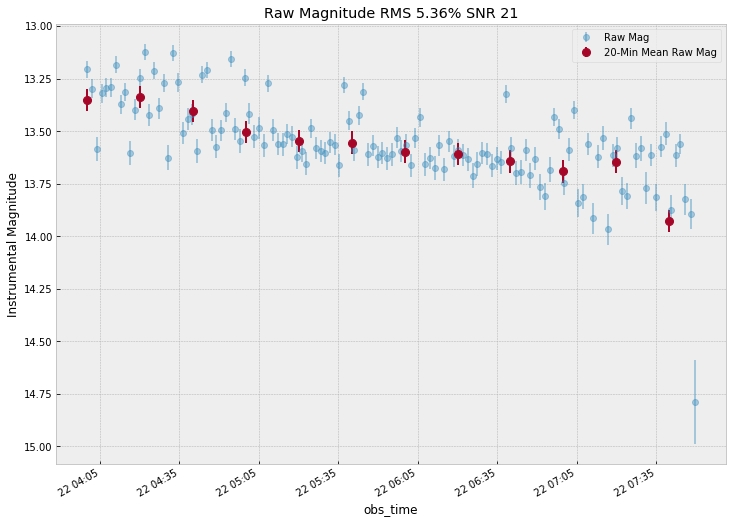

In [11]:
min_bin = 20
plt.figure(figsize=(12, 9))
target_table.mag_auto.plot(ls='', marker='o', yerr=target_table.magerr_auto, alpha=0.4, label='Raw Mag')
target_table.resample(f'{min_bin}T').mean().mag_auto.plot(ls='', marker='o', ms=8, yerr=target_table.magerr_auto.mean(), label=f'{min_bin}-Min Mean Raw Mag')
plt.title(f'Raw Magnitude RMS {target_table.magerr_auto.mean():.02%} SNR {target_table.snr.mean():.0f}')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

#### Differential photometry

Get some of the bright stars in the sequence and use them to normalize the target.

In [16]:
bright_stars = sources.groupby('id').snr.mean().sort_values(ascending=False).index.values[1:5]

bright_table = sources.loc[np.isin(sources.id, bright_stars)]

In [17]:
corrected_flux = (target_table.flux_auto / bright_table.groupby('obs_time').flux_auto.sum())

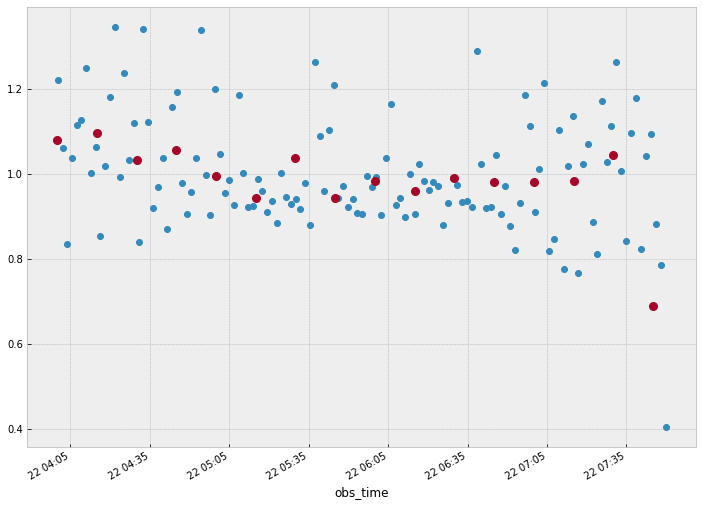

In [18]:
plt.figure(figsize=(12, 9))
(corrected_flux / corrected_flux.mean()).plot(ls='', marker='o')
(corrected_flux / corrected_flux.mean()).resample('15T').mean().plot(ls='', marker='o', ms=8)

**Todo** Show the color channel photometry

#### Find similar stars

Because a simple differential photometry doesn't work well we need to find a suitable set of reference stars that undergo the same changes (e.g. airmass, cloud cover, etc) as our target star.

Ultimately we are concerned about how the flux of our target changes with respect to a suitable set of reference stars and therefore we need to be careful **not** to use flux as a selection parameter for determining the "best" reference stars. That is, we **do not** want to choose reference stars that undergo a reduction of flux in the middle of the observation as this will hide the transit signal in our target.

We can marginalize across the flux by normalize each stamp to the total flux in that one stamp.



#### Formal Description

Each Postage Stamp Cube (PSC) is represented by the $m \times n$ matrix $P$ where $m$ represents the number of frames in the observation and $n$ the number of pixels in a frame. Note that we treat each stamp as a 1-D array and thus use a single index for traversing a stamp. There are a total of $p$ different PSC in an observation. The notation $P_{ij}^k$ would represent pixel $j$ in frame $i$ of stamp $k$.

The algorithm compares a target star to a number of reference stars. We will represent the target matrix as $T_0 = T$ and each reference as $P^k$. Each star in the image will take turns being the target and all other stars will be the reference for that run.

1. **Normalize**: Normalize each stamp $k$ to obtain $\hat{P^k}$, where each pixel $j$ in frame $i$ is given by: 
    
    $$ \hat{P_{ij}^k} = \frac{P_{ij}^k}{ \sum_{j=1}^{n}{P_{ij}^k} } $$
    
    for $(i = 0,...,m)$ frames. This normalized stamp has effectively marginalized the flux of the star and represents the shape of the star as it falls on the detectors. This shape will be compared both spatially and temporally in order to find "similar" stars.

2. **Find Reference Stars**: Find other sources that have the same morphology as target by comparing normalized stamps. Comparison is a summed-squared difference between the pixels for each frame of the observation. That is, 

    $$ v_k = \sum_{i=1}^m{ \sum_{j=1}^n {(\hat{T}_{ij} - \hat{P}_{ij}^k)^2} } $$

    where $(k=0,...,p)$ and $\hat{T}_{ij}$ and $\hat{P_{ij}^k}$ represent the pixel value at frame $i$ and index $j$ for the normalized target and reference $k$ respectively. We want to find the values of $k$ (which are index numbers) for which $v_k$ is a minimum, noting that when $\hat{T} = \hat{P^k}$ then $v_k = 0$ (i.e. a the target and the reference are perfect matches). 
    
    The ordered set of $v_k$ values is given as $V_l$ such that $V_0$ corresponds to the index number of the best match between $\hat{T}$ and $\hat{P}$ and a higher $l$ means there the index number is less of a match. Note that the index of $V$ is the same as the index numbers $k$ from $k=0,...,p$.
        
    This is performed for all references in $p$, which could potentially be minimized by some smart clustering of stars.